In [60]:
!pip install networkx

In [0]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

<h1> Assumption 0</h1>




In [0]:
population_ch = 8.57 * 10**6
population_it = 60.58 * 10**6
population_synthetic=6000 

<h1> Assumption 1</h1>

In [0]:

def p_function(n):
  random_encounter = np.random.random()

  return random_encounter/(n-1)
  

def b_subset_of_a(a,b):
  """
  Function to check if all the edges of the previous model were send to the next model
  """
  counter = 0
  big_set = []
  small_set = []
  for i in a:
    big_set.append(tuple(sorted(i)))
  for i in b:
    small_set.append(tuple(sorted(i)))
  if set(small_set).issubset(big_set):
    return True
  return False



def preferential_attachement(n_people: int, n_edges: int):
  """
  Constructs a Barabasi Albert Graph for a given number of people.
  The graph is constructed iteratively, where at every step a new node is added
  and connected to n_edges of other nodes. This should result in hubs.
  """
  return nx.barabasi_albert_graph(n_people, n_edges)

In [0]:
def model(n, p, k, sizes, probs):
  # Assumption 1.
  # in is defined by assumption 0, and p*(n-1) is the expected number of connections a person has
  G1 = nx.erdos_renyi_graph(n, p, directed=False)
  # Assumption 1.2
  G2 = nx.stochastic_block_model(sizes, probs, seed=0)
  # Assumption 1.3
  G3 = nx.barabasi_albert_graph(n, k)
  #Get edges from a graph
  #output (u,v) u and v are the nodes, which are connected to each other
  connections = G2.edges()
  G1.add_edges_from(connections)
  G1 = G1.to_undirected()
  return G1


#G = model(100,0.1,2,[75, 75, 300],[[0.25, 0.05, 0.02],[0.05, 0.35, 0.07],[0.02, 0.07, 0.40]])

<h1> Assumption 2</h1>


In [0]:
def initial_infection(g, people_infected_perc):
  healthy = 0
  infected = 1
  recovered = 2

  already_infected = True

  size = len(g)
  people_infected = int(people_infected_perc * size)
  
  #initial all node states
  for i in g.nodes():
    g.nodes[i]['state'] = healthy
    g.nodes[i]['contact'] = 0
    g.nodes[i]['contact_with_infected'] = 0
    g.nodes[i]['incubation_time'] = 0

  #initial infected nodes
  for i in range(people_infected):
    already_infected = False
    while not already_infected:
      seed = np.random.randint(people_infected)
      if g.nodes[seed]['state'] != infected:
        g.nodes[seed]['state'] = infected
        already_infected = True

  return g




<h1> Assumption 3 + 4</h1>

In [0]:
def contact_and_infection(g,i,meeting_rand, meet_probability, met_infected = False, infection_rate = None):
  if meeting_rand < meet_probability:
    if not g.nodes[i]['contact']:
      g.nodes[i]['contact'] = 1
    else:
      g.nodes[i]['contact'] =+ 1
    if met_infected:
      if g.nodes[i]['contact_with_infected']:
        g.nodes[i]['contact_with_infected'] =+ 1
      else:
        g.nodes[i]['contact_with_infected'] = 1
      infection_rand = np.random.random()
      if g.nodes[i]['incubation_time'] > 0:
        if infection_rand < infection_rate:
          g.nodes[i]['state'] = infected


def interaction_with_people(g, population, infection_rate, recovery_rate, lockdown = False, people_met_in_lockdown = None, sociable = False):
  people_chosen = np.random.randint(population)
  
  healthy = 0
  infected = 1
  recovered = 2

  meet_probability = 0

  if lockdown:
    contacts = people_met_in_lockdown
    meet_probability = 0.1
  else:
    #this variable could be changed
    contacts = population * people_chosen
    meet_probability = 0.7

  for i in g.nodes():
    neighbors = g.neighbors(i)
    for neighbor in neighbors:
      meeting_rand = np.random.random()
      if g.nodes[i]['state'] == healthy:
        contact_and_infection(g,i, meeting_rand, meet_probability)
        
      elif g.nodes[i]['state'] == infected:
        contact_and_infection(g,i,meeting_rand, meet_probability, True, infection_rate)
        recover_rand = np.random.random()
        if recover_rand < recovery_rate:
          g.nodes[i]['state'] = recovered


  return g

<h1> Assumption 5 </h1>

In [0]:
def duration_of_infection_remaining(g, incubation_period: int):
  """
  Assuming that people are only infectious for a given timeframe.
  Hence, they can only change the state of other people given their infection happened <= time_infected
  """
  g.nodes[i]['incubation_time'] = incubation_period

def update_incubation_period(g, incubation_period: int):
  g.nodes[i]['incubation_time'] =- 1

  
  

<h1> Model running </h1>

In [0]:

#input parameter

timestep = 10

#erdos renyi model
p = 0.1

#barabasi model
k = 2

#input parameter assumption 2
people_infected = 0.001
population = 8.57 * 10**6

#stochastic block model
sizes = [75, 75, 300]
probs = [[0.25, 0.05, 0.02],
        [0.05, 0.35, 0.07],
        [0.02, 0.07, 0.40]]




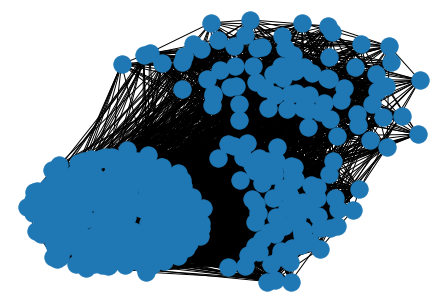

In [70]:
n = 10

g = model(n, p, k, sizes, probs)
initial_infection(g,0.1)
interaction_with_people(g, 10, 0.1, 0.05, True, 2, True)
nx.draw(g)